In [1]:

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

## Prepare Data

Get the data from keras.dataset

In [2]:
from tensorflow.keras.datasets import fashion_mnist # BUT NOTE, this is not mnist, but fashion_mnist
from tensorflow.keras.utils import to_categorical

num_classes = 10 
image_size = 784

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

4423680/4422102 [==============================] - 0s 0us/step


###  Convert the images from 3D to 2D arrays. 

The data comes in 3D: Height, Width, and Color-channels.  

In [3]:

conv_training_data = training_images.reshape(60000, 28, 28, 1)
conv_test_data = test_images.reshape(10000, 28, 28, 1)

In [4]:
def plot_acc_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')

    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()


### Fashion MNIST is a More Challenging Dataset
This time, we're using a new dataset called "Fashion MNIST". Like the handwritten digits dataset, this is a set of grayscale images each 28 by 28 pixels. However, the subject of these images is very different from the handwritten digits dataset. Instead, these are images of fashion objects.

This dataset was built as a "drop in" replacement for MNIST because neural networks can solve the MNIST digits problem a bit too easily.

Let's take a look at some:

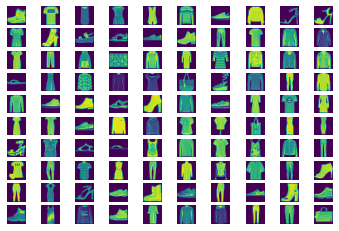

In [5]:
# Lets visualize the first 100 images from the dataset
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')
    plt.imshow(training_images[i])

In [6]:
i = 0 # So we can look at one at a time...

# So we can see the label
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

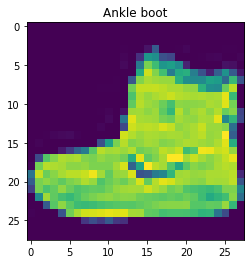

In [7]:
label = np.argmax(training_labels[i])
plt.title(label_map[label])
#plt.imshow(training_images[i], cmap='Greys')
plt.imshow(training_images[i])
i += 1


10 classes of image:

~~~
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
~~~

This is a bigger challenge than the handwritten digits.

#### For Comparison, A Traditional ANN
Let's quickly verify that a standard ANN that worked well in the context of MNIST does less well in Fashion MNIST:

In [8]:
# Recall from the Optimizers section that we were able to get 
# ~97% test accuracy with this network on regular MNIST:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, SpatialDropout2D, GlobalAveragePooling2D


model = Sequential()

model.add(Dense(units=128, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 2.3990 - accuracy: 0.6591 - val_loss: 0.8380 - val_accuracy: 0.7392
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.7213 - accuracy: 0.7491 - val_loss: 0.6932 - val_accuracy: 0.7657
Epoch 3/10
422/422 [==============================] - 1s 3ms/step - loss: 0.6311 - accuracy: 0.7753 - val_loss: 0.6431 - val_accuracy: 0.7950
Epoch 4/10
422/422 [==============================] - 2s 4ms/step - loss: 0.5674 - accuracy: 0.8000 - val_loss: 0.5473 - val_accuracy: 0.8125
Epoch 5/10
422/422 [==============================] - 2s 4ms/step - loss: 0.5188 - accuracy: 0.8167 - val_loss: 0.5156 - val_accuracy: 0.8225
Epoch 6/10
422/422 [==============================] - 2s 4ms/step - loss: 0.4754 - accuracy: 0.8329 - val_loss: 0.4747 - val_accuracy: 0.8335
Epoch 7/10
422/422 [==============================] - 2s 4ms/step - loss: 0.4321 - accuracy: 0.8474 - val_loss: 0.4571 - val_accuracy: 0.8392
Epoch 

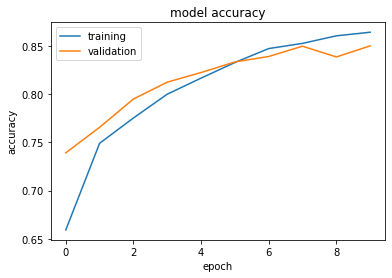

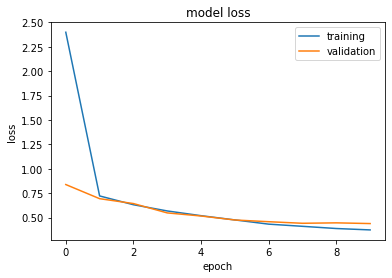

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_data, training_labels, batch_size=128, epochs=10, verbose=True, validation_split=.1)
plot_acc_loss(history)

In [10]:
loss, accuracy = model.evaluate(test_data, test_labels, verbose=True)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

313/313 [==============================] - 0s 1ms/step - loss: 0.4676 - accuracy: 0.8408
Test loss: 0.468
Test accuracy: 0.841


Notes
Not bad, but not nearly as good as we were able to achieve with regular MNIST. And, looks like during the last few epochs we may have started to overfit. Some regularization e.g. Dropout could help.

### Now, Lets Build a CNN

In [11]:

model = Sequential()

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',))

# Flatten turns our final convolutional layer's output shape from (28, 28, 32) => 1x25088 (!)
model.add(Flatten())

# The tail of the network is a standard ANN and can also be deep or shallow depending
# on the network architecture.
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Lets fit it with identical parameters and see what happens...
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

That flatten layer into a dense layer is exploding the parameter count. We're going to have to solve this problem or buy a very nice GPU (or both). This is something CNN designers must be aware of, that the parameter counts can explode when we transition to the flat ANN portion of the network.

We'll use heavy striding as well as a new type of layer called GlobalAveragePooling to mitigate this problem soon.

In [12]:


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)
#plot_acc_loss(history)



### Reduce computational cost

* Striding 
* Dropout and Spatial Dropout
Regular Dropout can be used on the ANN sections of our networks. Spatial dropout is a very similar idea that drops out entire kernals at a time.
* Global Average Pooling
Global average pooling is an alternative to Flatten. Instead of preserving all the values and simply reshaping them into a flat vector global average pooling returns the average of all the values in a single filter map. This does represent a loss of some of the spatial information, and isn't always appropriate (flatten is better for object localization for example) but really helps with the parameter explosion when transition to dense layers.

In [13]:

model = Sequential()

# Note, strides will shrink the output size.
model.add(Conv2D(64, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(28, 28, 1)))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

model.add(Conv2D(265, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

# GAB instead of Flatten, which will be a huge paramter saving move.
model.add(GlobalAveragePooling2D())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# A bit of standard dropout
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 265)         305545    
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 4, 4, 265)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 265)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

Notes:
Way fewer parameters, nice.

Note the shape of the outputs, the final convolutional layer is only producing 4x4 feature maps but 256 of them.

Lets see how it does...

Epoch 1/10
422/422 [==============================] - 7s 17ms/step - loss: 0.8310 - accuracy: 0.7035 - val_loss: 0.4312 - val_accuracy: 0.8408
Epoch 2/10
422/422 [==============================] - 7s 17ms/step - loss: 0.4720 - accuracy: 0.8381 - val_loss: 0.3625 - val_accuracy: 0.8687
Epoch 3/10
422/422 [==============================] - 7s 17ms/step - loss: 0.3933 - accuracy: 0.8631 - val_loss: 0.3173 - val_accuracy: 0.8862
Epoch 4/10
422/422 [==============================] - 7s 17ms/step - loss: 0.3548 - accuracy: 0.8773 - val_loss: 0.3024 - val_accuracy: 0.8912
Epoch 5/10
422/422 [==============================] - 7s 17ms/step - loss: 0.3197 - accuracy: 0.8871 - val_loss: 0.2937 - val_accuracy: 0.8888
Epoch 6/10
422/422 [==============================] - 7s 17ms/step - loss: 0.2979 - accuracy: 0.8931 - val_loss: 0.2938 - val_accuracy: 0.8947
Epoch 7/10
422/422 [==============================] - 7s 17ms/step - loss: 0.2826 - accuracy: 0.8993 - val_loss: 0.2879 - val_accuracy: 0.8980

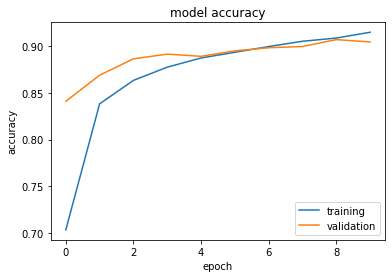

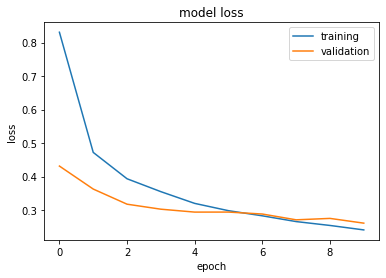

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=10, verbose=True, validation_split=.1)

plot_acc_loss(history)

Notes:
Much faster, as we had hoped.

Much lesss overfitting, as we had hoped.

Better top-line validation and test accuracies.

Win, win, win.

In [15]:
loss, accuracy = model.evaluate(conv_test_data, test_labels, verbose=True)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

313/313 [==============================] - 1s 2ms/step - loss: 0.2764 - accuracy: 0.9010
Test loss: 0.276
Test accuracy: 0.901
